try to repeat and improve:

[How to Optimize Your Investments for SKAT](https://fesasdelli.medium.com/how-to-optimize-your-investments-for-skat-7ea0841900c9)

In [78]:
import numpy as np
import pandas as pd
import matplotlib as plt

# Input parameters

Define common constants

In [4]:
stock_growth_perc = 8

In [17]:
skat_stock_low_rate_perc = 27
skat_stock_high_rate_perc = 42

In [18]:
stock_top_skat_old = 56500
stock_top_skat_old_couple = stock_top_skat_old * 2
stock_top_skat = 67500
stock_top_skat_couple = stock_top_skat * 2

In [73]:
total_expense_perc_fund_avg = 0.55
total_expense_perc_etf_avg = 0.15

# Calculations

## Tax related functions

In [52]:
def tax_stock(income: float, stock_top_skat: float) -> float:
    low = min(income, stock_top_skat) * (skat_stock_low_rate_perc / 100)
    if income <= stock_top_skat:
        return low
    high = (income - stock_top_skat) * (skat_stock_high_rate_perc / 100)
    return low + high

assert 27.0 == tax_stock(100, stock_top_skat)
assert 67500.0*0.27 == tax_stock(stock_top_skat, stock_top_skat)
assert 67500.0*0.27 + 42.0 == tax_stock(stock_top_skat+100, stock_top_skat)
assert 42.0 == tax_stock(100, 0.0)

In [170]:
def tax_aktie_spare_konto(income: float) -> float:
    return income * 0.17

assert 0.0 == tax_aktie_spare_konto(0.0)
assert 17.0 == tax_aktie_spare_konto(100)
assert 0.17*10**9 == tax_aktie_spare_konto(10**9)

## Growth functions

In [173]:
def stock_growth_taxed_after_realisation(v: float, years: int, stock_growth_perc: float, total_expense_perc: float, 
                                         stock_top_skat: float) -> float:
    growth_factor = 1.0 + stock_growth_perc / 100
    expense_factor = 1.0 - total_expense_perc / 100
    r = v * (growth_factor * expense_factor)**years
    income = r - v
    tax = tax_stock(income, stock_top_skat)
    return r - tax

def assert_small_diff(val1: float, val2: float) -> None:
    assert abs(val1 - val2) <= 1.0

assert_small_diff(stock_growth_taxed_after_realisation(10**5, 0, 8, 0.55, stock_top_skat_old), 10.0**5)
# check against the article: https://fesasdelli.medium.com/how-to-optimize-your-investments-for-skat-7ea0841900c9
assert_small_diff(stock_growth_taxed_after_realisation(10**5, 10, 8, 0.55, stock_top_skat_old), 168974.0)
assert_small_diff(stock_growth_taxed_after_realisation(10**5, 20, 8, 0.55, stock_top_skat_old), 292577.0)

In [178]:
def stock_growth_taxed_yearly(v: float, years: int, stock_growth_perc: float, total_expense_perc: float,
                              stock_top_skat: float) -> float:
    r = v
    growth_factor = 1.0 + stock_growth_perc / 100
    expense_factor = 1.0 - total_expense_perc / 100
    for year in range(years):
        r_new = r * growth_factor * expense_factor
        income = r_new - r
        tax = tax_stock(income, stock_top_skat)
        r = r_new - tax
    return r

assert_small_diff(stock_growth_taxed_yearly(10**5, 0, 8, 0.15, stock_top_skat_old), 10.0**5)
# off with the article: https://fesasdelli.medium.com/how-to-optimize-your-investments-for-skat-7ea0841900c9
stock_growth_taxed_yearly(10**5, 10, 8, 0.15, stock_top_skat_old) - 182253.0
stock_growth_taxed_yearly(10**5, 20, 8, 0.15, stock_top_skat_old) - 357187.0

-7814.227209489036

-52898.14547340467

In [180]:
def aktie_spare_konto_growth(v: float, years: int, stock_growth_perc: float, total_expense_perc: float) -> float:
    r = v
    growth_factor = 1.0 + stock_growth_perc / 100
    expense_factor = 1.0 - total_expense_perc / 100
    for year in range(years):
        r_new = r * growth_factor * expense_factor
        income = r_new - r
        tax = tax_aktie_spare_konto(income)
        r = r_new - tax
    return r

assert_small_diff(aktie_spare_konto_growth(10**5, 0, 8, 0.15), 10.0**5)
# off with the article: https://fesasdelli.medium.com/how-to-optimize-your-investments-for-skat-7ea0841900c9
aktie_spare_konto_growth(10**5, 10, 8, 0.15) - 186576.0
aktie_spare_konto_growth(10**5, 20, 8, 0.15) - 363457.0

1235.4157872181968

-10725.721000006073

# functions to visualize results

In [141]:
def generate_df(initial_value: float, stock_growth_perc: float, stock_top_skat: float,
                total_expense_perc_fund_avg: float, total_expense_perc_etf_avg: float, years: int):
    data = []
    for year in range(years+1):
        data.append([
            stock_growth_taxed_after_realisation(initial_value, year, stock_growth_perc, total_expense_perc_fund_avg, stock_top_skat),
            stock_growth_taxed_yearly(initial_value, year, stock_growth_perc, total_expense_perc_etf_avg, stock_top_skat),
            aktie_spare_konto_growth(initial_value, year, stock_growth_perc, total_expense_perc_etf_avg),
        ])
    return pd.DataFrame(data=data, columns=['fund', 'etf', 'ask'])

In [193]:
def title(initial_value: float, stock_top_skat: float, total_expense_perc_fund_avg: float,
          total_expense_perc_etf_avg: float):
    return f"""growth of {initial_value:,} DKK
stock top skat {stock_top_skat:,} DKK
total fund expense {total_expense_perc_fund_avg}%
total ETF expense {total_expense_perc_etf_avg}%
"""

In [194]:
def draw(initial_value: float, stock_growth_perc: float, stock_top_skat: float,
         total_expense_perc_fund_avg: float, total_expense_perc_etf_avg: float, years: int):
    df = generate_df(initial_value, stock_growth_perc, stock_top_skat_old, total_expense_perc_fund_avg, total_expense_perc_etf_avg, years)
    _ = df.plot(title=title(initial_value, stock_top_skat, total_expense_perc_fund_avg, total_expense_perc_etf_avg),
                xticks=range(years+1), grid=True, figsize=(16, 9))

# Experiments

## Repeat the article

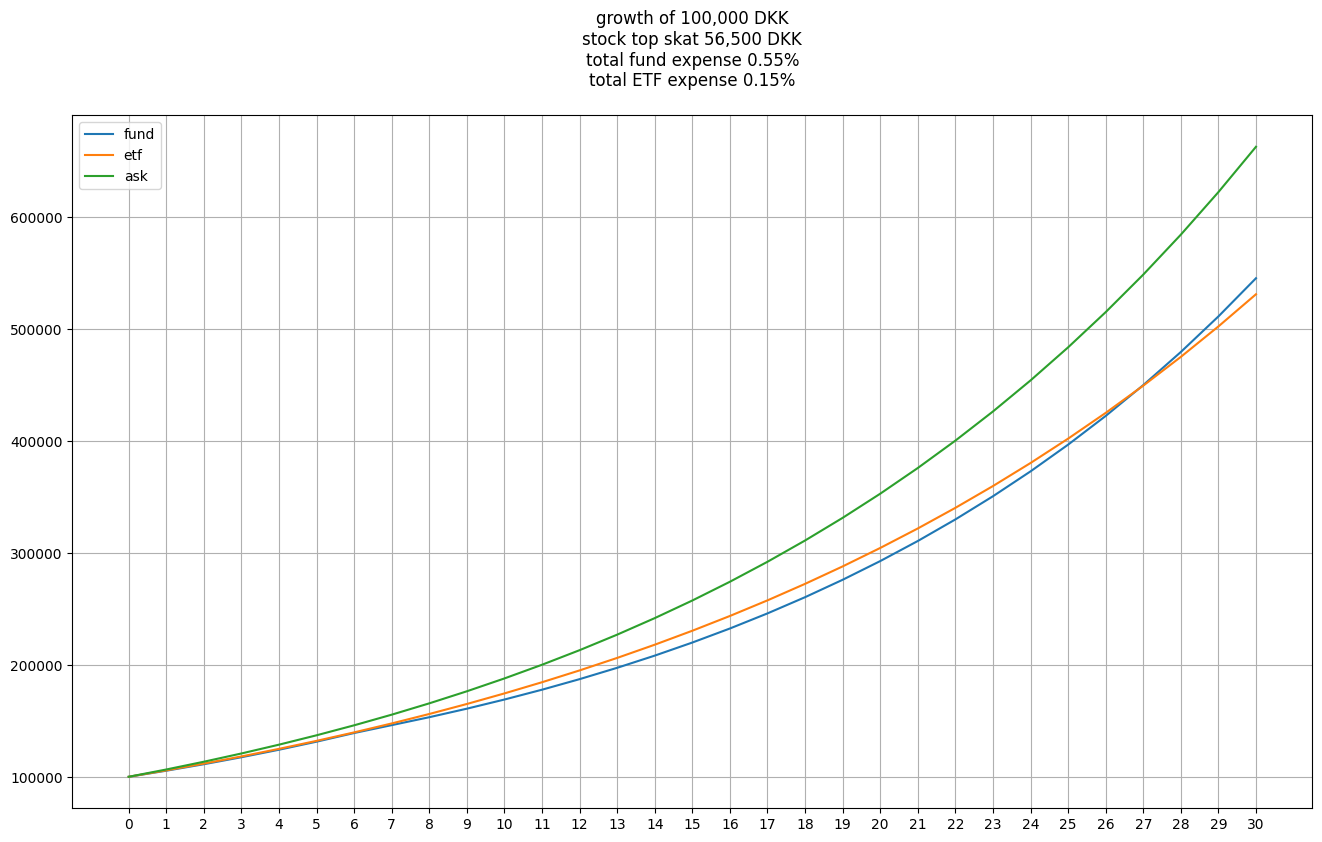

In [195]:
draw(10**5, 8, stock_top_skat_old, total_expense_perc_fund_avg, total_expense_perc_etf_avg, 30)

## use current stock top skat value

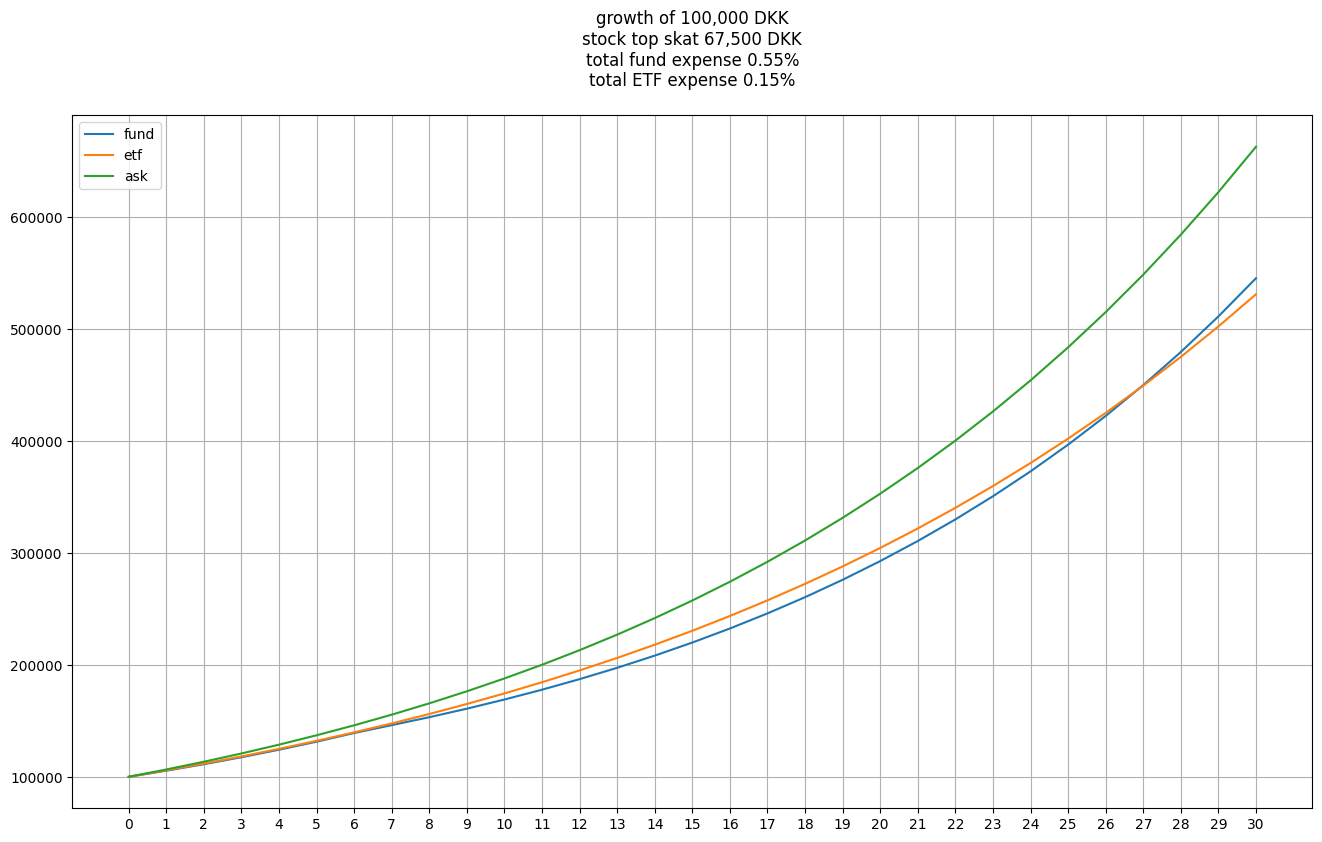

In [196]:
draw(10**5, 8, stock_top_skat, total_expense_perc_fund_avg, total_expense_perc_etf_avg, 30)

## modern top skat value for a couple

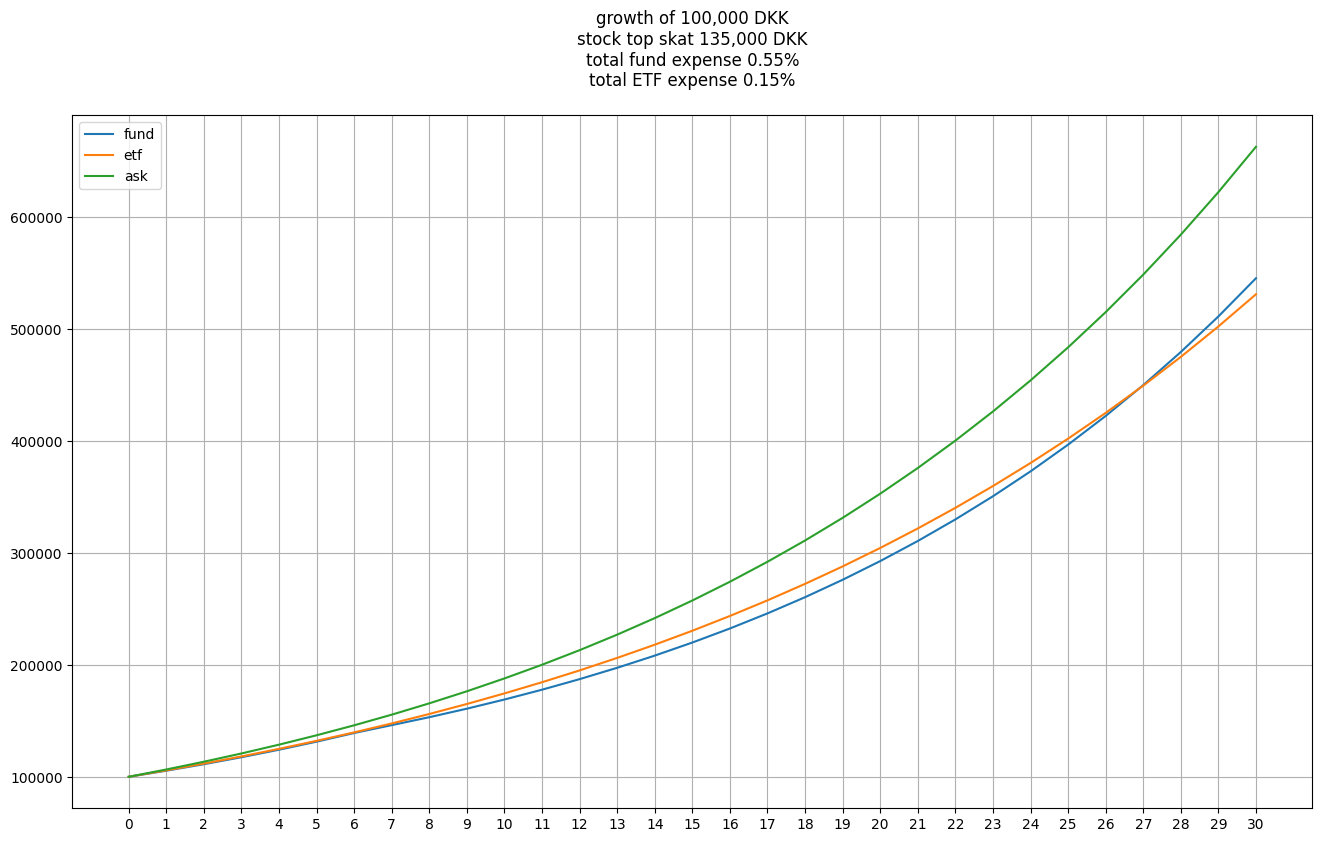

In [197]:
draw(10**5, 8, stock_top_skat_couple, total_expense_perc_fund_avg, total_expense_perc_etf_avg, 30)

## more actual base value for investments

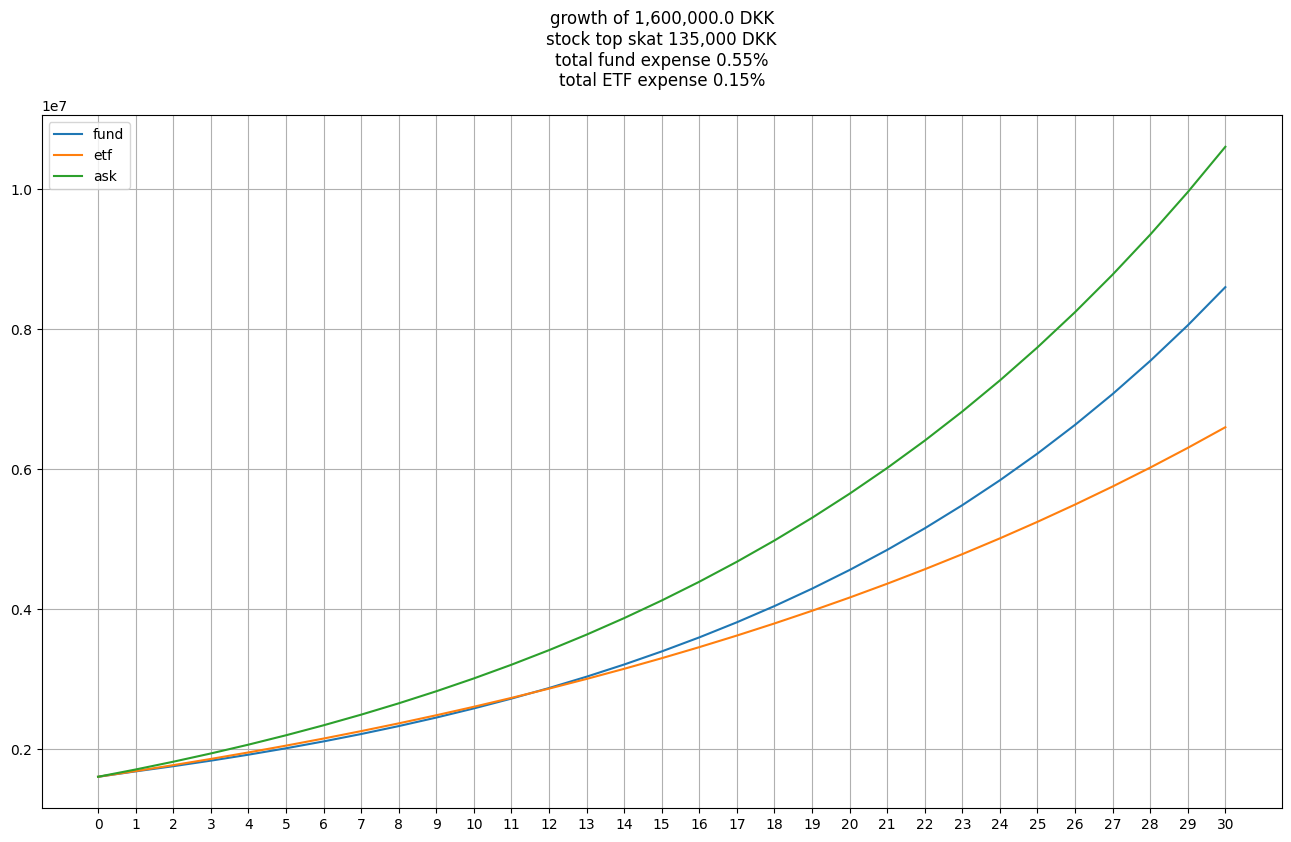

In [203]:
draw(1.6*10**6, 8, stock_top_skat_couple, total_expense_perc_fund_avg, total_expense_perc_etf_avg, 30)

## check slightly lower expenses for real global fund

[Danske Inv Global Indeks, kl DKK d](https://www.nordnet.dk/markedet/investeringsforeninger-liste/16100163-danske-inv-global)

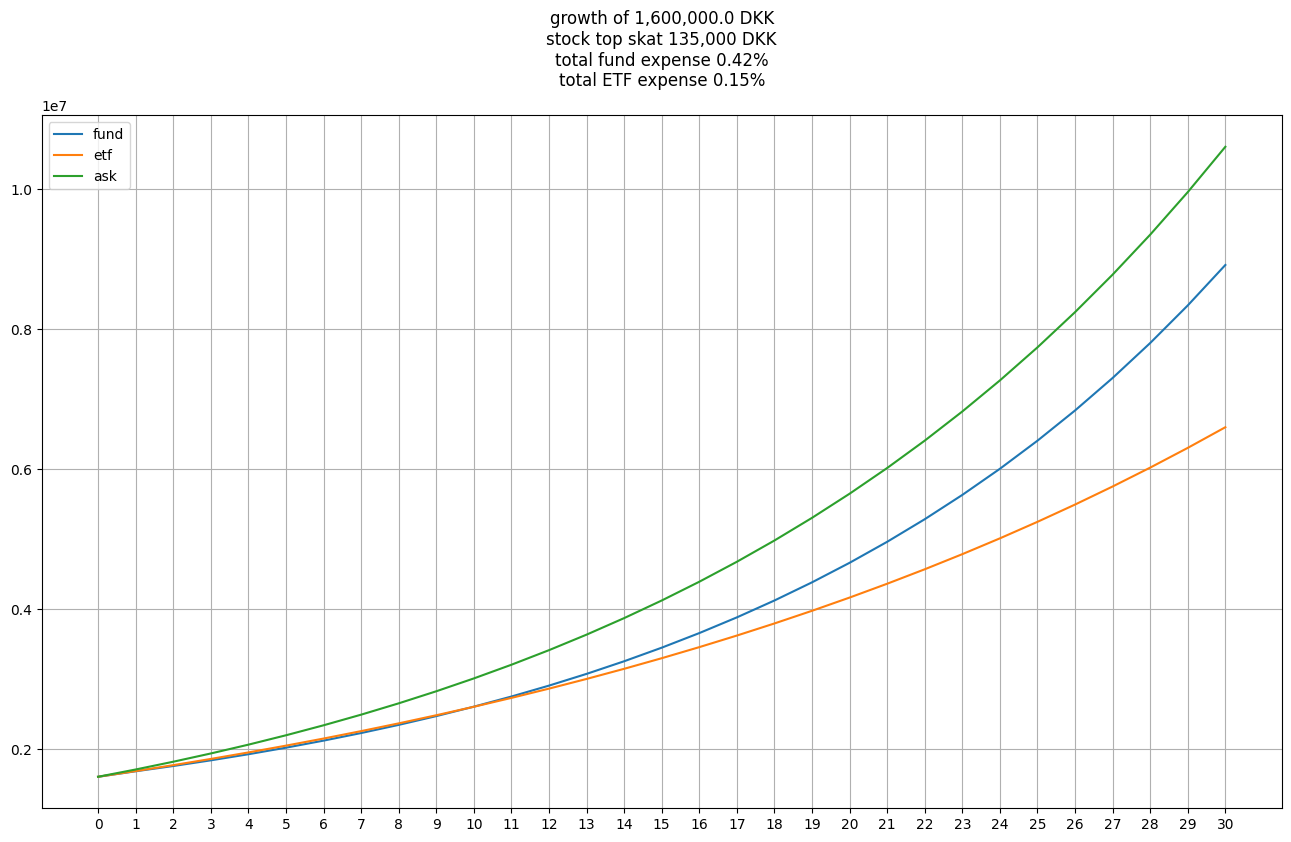

In [205]:
draw(1.6*10**6, 8, stock_top_skat_couple, 0.42, total_expense_perc_etf_avg, 30)

## check slightly lower expenses for real global ETF

[Vanguard FTSE Developed World UCITS ETF Acc](https://www.justetf.com/en/etf-profile.html?groupField=none&age=etfAgeThree&fsg=more500&replicationType=replicationType-full&replicationType=replicationType-sampling&ic=Vanguard&sortField=fundSize&sortOrder=desc&assetClass=class-equity&region=World&from=search&isin=IE00BK5BQV03)

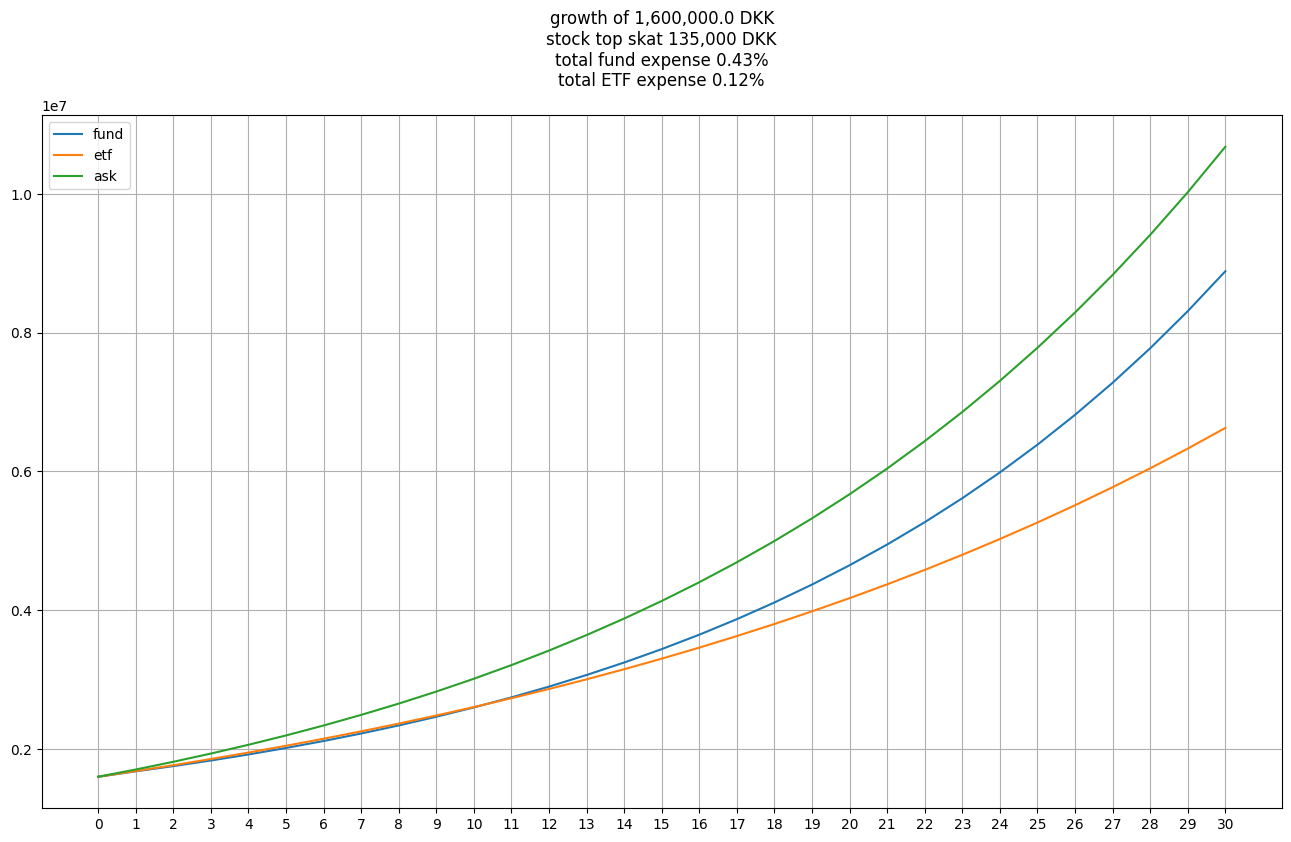

In [206]:
draw(1.6*10**6, 8, stock_top_skat_couple, 0.43, 0.12, 30)

# Results

1. In the short-term, a fund performs better than an ETF for usual investment account (not specially taxed as aktiesparekonto (aka ASK)) especially with a low starting base. The main reason for that is that ETFs hit stock top tax after some time only.
3. In the long-term, a fund performs better than an ETF for usual investment account (not specially taxed as aktiesparekonto (aka ASK)) especially with a higher (more realistic) base. The main reason is that we pay taxes on realization and all the years the delayed taxes start to grow significantly.  